_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c7_interpolated_2450_50.csv")
training_set = data.iloc[:, 1]
training_set

0       92.600000
1       92.387115
2       92.174230
3       91.961345
4       91.748459
          ...    
2495    62.430607
2496    62.422956
2497    62.415304
2498    62.407652
2499    62.400000
Name: C7, Length: 2500, dtype: float64

In [6]:
test = training_set.tail(50)
test
training_set = training_set.head(2450)
training_set

0       92.600000
1       92.387115
2       92.174230
3       91.961345
4       91.748459
          ...    
2445     0.289427
2446     0.034906
2447     0.000000
2448     0.444268
2449     1.085368
Name: C7, Length: 2450, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,92.600000,0.000298
1,92.387115,0.000298
2,92.174230,0.000297
3,91.961345,0.000297
4,91.748459,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

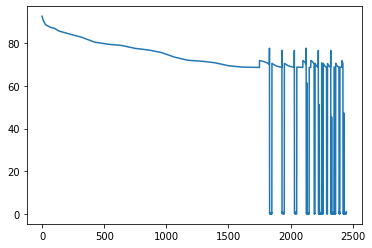

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

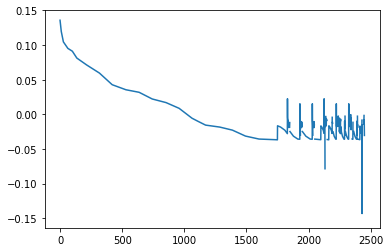

In [11]:
import numpy as np
c0 = 89.3180  # Value for C0
K0 = -0.0010  # Value for K0
K1 = 0.0001  # Value for K1
a = 0.0000    # Value for a
b = -0.0204    # Value for b
c = 2.2194    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 175, n_out = 50)


cols_to_drop = []
for i in range(2, 176):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-175)  var1(t-174)  var1(t-173)  var1(t-172)  var1(t-171)  \
175    92.600000    92.387115    92.174230    91.961345    91.748459   
176    92.387115    92.174230    91.961345    91.748459    91.535574   
177    92.174230    91.961345    91.748459    91.535574    91.322689   
178    91.961345    91.748459    91.535574    91.322689    91.109804   
179    91.748459    91.535574    91.322689    91.109804    90.896919   

     var1(t-170)  var1(t-169)  var1(t-168)  var1(t-167)  var1(t-166)  ...  \
175    91.535574    91.322689    91.109804    90.896919    90.691597  ...   
176    91.322689    91.109804    90.896919    90.691597    90.579552  ...   
177    91.109804    90.896919    90.691597    90.579552    90.467507  ...   
178    90.896919    90.691597    90.579552    90.467507    90.355462  ...   
179    90.691597    90.579552    90.467507    90.355462    90.243417  ...   

     var1(t+45)  var2(t+45)  var1(t+46)  var2(t+46)  var1(t+47)  var2(t+47)  \
175   84.280019    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-150:]
trainX = train[:,:-150]

In [16]:
forecasty = forecast[:,-150:]
forecastX = forecast[:,:-150]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(2225, 1, 126) (2225, 150) (1, 1, 126)


In [18]:
C0 = tf.Variable(89.3180, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0010, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(0.0001, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(-0.0204, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.2194, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
28/28 [==============================] - 2s 18ms/step - loss: 5362.1040 - val_loss: 3218.3630
Epoch 2/500
28/28 [==============================] - 0s 4ms/step - loss: 5153.1172 - val_loss: 3052.8608
Epoch 3/500
28/28 [==============================] - 0s 4ms/step - loss: 4973.6123 - val_loss: 2950.2556
Epoch 4/500
28/28 [==============================] - 0s 4ms/step - loss: 4842.5371 - val_loss: 2873.0405
Epoch 5/500
28/28 [==============================] - 0s 4ms/step - loss: 4721.2065 - val_loss: 2799.9724
Epoch 6/500
28/28 [==============================] - 0s 4ms/step - loss: 4604.7124 - val_loss: 2729.8450
Epoch 7/500
28/28 [==============================] - 0s 3ms/step - loss: 4482.2583 - val_loss: 2653.6758
Epoch 8/500
28/28 [==============================] - 0s 3ms/step - loss: 4363.7544 - val_loss: 2583.5078
Epoch 9/500
28/28 [==============================] - 0s 4ms/step - loss: 4251.3584 - val_loss: 2517.2246
Epoch 10/500
28/28 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 395ms/step


In [20]:
forecastX.shape

(1, 1, 126)

In [21]:
forecast_without_mc.shape

(1, 126)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 186)

In [24]:
fforecast = inv_yhat_without_mc[:,-150:]

In [25]:
fforecast.shape

(1, 150)

In [26]:
final_forecast = fforecast[:,0:150:3]

In [27]:
fforecast.shape

(1, 150)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[0.00000000e+00, 7.04212418e+01, 7.00683006e+01, 6.97153595e+01,
        6.94312092e+01, 6.92547386e+01, 6.90782680e+01, 6.89017974e+01,
        6.87893324e+01, 6.87641223e+01, 1.06601441e+00, 6.04974806e-01,
        7.04604575e+01, 7.01075163e+01, 6.97545752e+01, 6.94508170e+01,
        6.92743464e+01, 6.90987758e+01, 6.89214052e+01, 6.87921335e+01,
        6.87669234e+01, 5.02604306e-01, 2.92042941e-01, 4.54188614e+01,
        2.91158468e-01, 8.49562730e-02, 1.54605360e-02, 7.24539340e-01,
        0.00000000e+00, 9.74744320e-01, 6.62910233e+01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.63608336e-01, 0.00000000e+00,
        4.75232333e-01, 5.51850736e-01, 1.04397535e-01, 1.43292212e+00,
        5.92755020e-01, 0.00000000e+00, 1.19628645e-01, 6.35984302e-01,
        3.39572072e-01, 0.00000000e+00, 0.00000000e+00, 1.49526566e-01,
        0.00000000e+00, 0.00000000e+00]])

In [30]:
final_forecast.shape

(1, 50)

In [31]:
test.shape

(50,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([62.77494022, 62.76728838, 62.75963654, 62.7519847 , 62.74433286,
       62.73668101, 62.72902917, 62.72137733, 62.71372549, 62.70607365,
       62.69842181, 62.69076997, 62.68311813, 62.67546628, 62.66781444,
       62.6601626 , 62.65251076, 62.64485892, 62.63720708, 62.62955524,
       62.6219034 , 62.61425155, 62.60659971, 62.59894787, 62.59129603,
       62.58364419, 62.57599235, 62.56834051, 62.56068867, 62.55303682,
       62.54538498, 62.53773314, 62.5300813 , 62.52242946, 62.51477762,
       62.50712578, 62.49947394, 62.49182209, 62.48417025, 62.47651841,
       62.46886657, 62.46121473, 62.45356289, 62.44591105, 62.43825921,
       62.43060736, 62.42295552, 62.41530368, 62.40765184, 62.4       ])

In [34]:
test.shape

(50,)

In [35]:
final_forecast.shape

(50,)

In [36]:
test.shape

(50,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

48.42597174221664
40.1595758492733
